In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

sns.set(color_codes=True)

In [2]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

In [3]:
from lightgbm import LGBMClassifier

<br>
<br>
<br>

### Data Collection

In [4]:
# loading preprocessed data
data = pd.read_csv("../pipeline_data/5_train_preprocessed.csv")
data.head(3)

,C6,C8,C1_1,C1_2,C1_3,C2_0,C2_1,C2_2,C2_3,C2_4,...,N17,N18,N19,N21,N22,N23,N24,N33,N35,Dependent_Variable
0,0,1,1,0,0,0,1,0,0,0,...,0.026969,0.735849,-1.075934,-0.85,-1.0,0.6875,-0.317073,-0.471698,-0.333333,0
1,0,1,0,1,0,0,0,0,1,0,...,-4.699231,-1.056604,-0.473452,0.40,-1.0,-0.2500,-0.731707,1.037736,-1.555556,1
2,0,1,1,0,0,1,0,0,0,0,...,0.000000,0.000000,0.000000,0.00,0.0,-0.4375,-0.780488,-0.452830,-0.444444,1


In [5]:
# seperating features
X = data.drop(['Dependent_Variable'], axis=1)
X.head(3)

,C6,C8,C1_1,C1_2,C1_3,C2_0,C2_1,C2_2,C2_3,C2_4,...,N16,N17,N18,N19,N21,N22,N23,N24,N33,N35
0,0,1,1,0,0,0,1,0,0,0,...,0.0,0.026969,0.735849,-1.075934,-0.85,-1.0,0.6875,-0.317073,-0.471698,-0.333333
1,0,1,0,1,0,0,0,0,1,0,...,0.0,-4.699231,-1.056604,-0.473452,0.40,-1.0,-0.2500,-0.731707,1.037736,-1.555556
2,0,1,1,0,0,1,0,0,0,0,...,0.0,0.000000,0.000000,0.000000,0.00,0.0,-0.4375,-0.780488,-0.452830,-0.444444


In [6]:
X.columns

Index(['C6', 'C8', 'C1_1', 'C1_2', 'C1_3', 'C2_0', 'C2_1', 'C2_2', 'C2_3',
       'C2_4', 'C2_6', 'C2_7', 'C2_999', 'C3_0', 'C3_1', 'C3_19', 'C3_2',
       'C3_3', 'C3_5', 'C3_7', 'C3_999', 'C4_0', 'C4_1', 'C4_12', 'C4_31',
       'C4_41', 'C4_999', 'C5_0', 'C5_1', 'C5_2', 'C5_4', 'C5_999', 'C7_0',
       'C7_1', 'C7_2', 'C7_4', 'C7_6', 'C7_999', 'N1', 'N2', 'N3', 'N4', 'N7',
       'N8', 'N9', 'N10', 'N10.1', 'N11', 'N12', 'N14', 'N15', 'N16', 'N17',
       'N18', 'N19', 'N21', 'N22', 'N23', 'N24', 'N33', 'N35'],
      dtype='object')

In [7]:
# seperating target
y = data[['Dependent_Variable']]
y.head(3)

,Dependent_Variable
0,0
1,1
2,1


<br>
<br>
<br>

### Recursive Feature Elimination

In [8]:
# will hold scores
train_scores = []
cross_val_scores = []

In [9]:
# params for LGBM
best_params = {
    'n_estimators': 400,
    'learning_rate': 0.10212499331506983,
    'num_leaves': 1160,
    'max_depth': 8,
    'min_data_in_leaf': 200,
    'lambda_l1': 0,
    'lambda_l2': 15,
    'min_gain_to_split': 7.151260846950484,
    'bagging_fraction': 0.7,
    'bagging_freq': 1,
    'feature_fraction': 0.5
}

In [ ]:
# initital list of features
feature_list = list(X.columns)

while len(feature_list) > 1:
    # training model
    clf = LGBMClassifier(**best_params, random_state=42)
    clf.fit(X[feature_list], np.ravel(y))

    # training score
    predictions = clf.predict_proba(X[feature_list])[:, 1]
    train_score = roc_auc_score(np.ravel(y), predictions)

    # cross val score
    scores = cross_val_score(LGBMClassifier(**best_params, random_state=42), X=X[feature_list], y=np.ravel(y), scoring='roc_auc', cv=10, n_jobs=-1)
    val_score = scores.mean()

    # adding scores to list
    train_scores.append(train_score)
    cross_val_scores.append(val_score)

    # removing 1 least important feature
    imp_series = pd.Series(clf.feature_importances_, index=X[feature_list].columns).sort_values()
    eliminated_feature = imp_series.index[0]
    feature_list.remove(eliminated_feature)

    print(f"eliminated feature: {imp_series.index[0]} ({imp_series[0]})")

In [11]:
print(len(train_scores))
print(len(cross_val_scores))

60
60


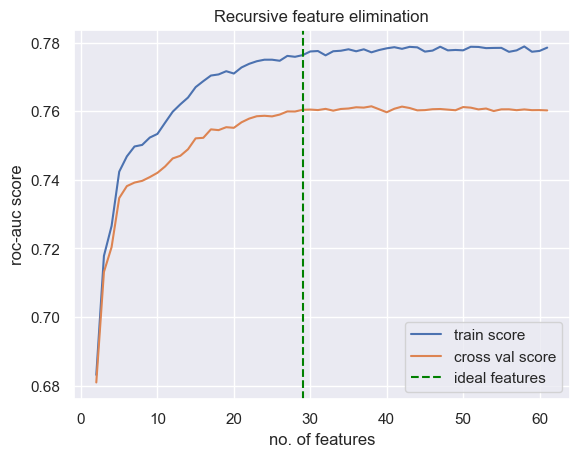

In [15]:
# plotting curve

sns.lineplot(x=range(61, 1, -1), y=train_scores, label='train score')
sns.lineplot(x=range(61, 1, -1), y=cross_val_scores, label='cross val score')
plt.axvline(x=29, color='green', linestyle='--', label='ideal features')
plt.legend()
plt.title('Recursive feature elimination')
plt.ylabel('roc-auc score')
plt.xlabel('no. of features')
plt.show()

29 seems to be ideal number of features, as the cross_val_score<br>
started dropping after that

The gap between training score and cross val score is reduced
during hyperparameter tunning

<br>
<br>
<br>

### Feature Selection

Feature selection using Recursive Feature Elimination technique

In [23]:
# excluded features after RFE
features_to_exclude = ['C3_3', 'C2_6', 'C3_2', 'C3_5', 'C2_999', 'C7_1', 'N21', 'C2_1', 'N2',
       'N14', 'C8', 'C2_7', 'C4_0', 'C7_999', 'C2_4', 'C7_6', 'C3_7', 'C2_2',
       'N16', 'C5_0', 'C4_12', 'C1_1', 'C3_1', 'C5_2', 'C7_2', 'C3_19',
       'C5_999', 'C4_999', 'C3_999', 'C7_0', 'C7_4', 'C4_31']

data.drop(features_to_exclude, axis=1, inplace=True)
X = data.drop(['Dependent_Variable'], axis=1)

In [24]:
X.shape

(28050, 29)

<br>
<br>
<br>

### LightGBM

LightGBM was choosed for RFE because:
- It is the most optimised tree based algorithm
- It is fast & effecient. Hence, provide quick RFE
- It performed better than other algorithms when tested on our data

<br>

In [25]:
clf = LGBMClassifier(**best_params, random_state=42)

In [26]:
clf.fit(X, np.ravel(y))

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.151260846950484, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.151260846950484
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, feature_fraction=0.5,
               lambda_l1=0, lambda_l2=15, learning_rate=0.10212499331506983,
               max_depth=8, min_data_in_leaf=200,
               min_gain_to_split=7.151260846950484, n_estimators=400,
               num_leaves=1160, random_state=42)

In [27]:
# score on training data
predictions = clf.predict_proba(X)[:, 1]
roc_auc_score(np.ravel(y), predictions)

0.7763878688086334

In [28]:
# cross validation score
scores = cross_val_score(clf, X=X, y=np.ravel(y), scoring='roc_auc', cv=10, n_jobs=-1)
scores.mean()

0.7601210575763395

In [30]:
# feature importance
pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)[:10]

N33      115
N1        80
N24       55
N3        55
N11       45
N23       40
N10.1     36
N10       35
N22       34
C3_0      31
dtype: int32

In [22]:
# pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False).index[-32:]

Index(['C3_3', 'C2_6', 'C3_2', 'C3_5', 'C2_999', 'C7_1', 'N21', 'C2_1', 'N2',
       'N14', 'C8', 'C2_7', 'C4_0', 'C7_999', 'C2_4', 'C7_6', 'C3_7', 'C2_2',
       'N16', 'C5_0', 'C4_12', 'C1_1', 'C3_1', 'C5_2', 'C7_2', 'C3_19',
       'C5_999', 'C4_999', 'C3_999', 'C7_0', 'C7_4', 'C4_31'],
      dtype='object')

<br>
<br>
<br>

In [31]:
# updated data
data.head()

,C6,C1_2,C1_3,C2_0,C2_3,C3_0,C4_1,C4_41,C5_1,C5_4,...,N15,N17,N18,N19,N22,N23,N24,N33,N35,Dependent_Variable
0,0,0,0,0,0,0,1,0,1,0,...,0.0,0.026969,0.735849,-1.075934,-1.0,0.6875,-0.317073,-0.471698,-0.333333,0
1,0,1,0,0,1,0,0,0,1,0,...,0.0,-4.699231,-1.056604,-0.473452,-1.0,-0.2500,-0.731707,1.037736,-1.555556,1
2,0,0,0,1,0,1,0,0,0,0,...,0.0,0.000000,0.000000,0.000000,0.0,-0.4375,-0.780488,-0.452830,-0.444444,1
3,0,0,0,0,0,0,0,0,0,0,...,1.0,-0.013778,-0.773585,0.894816,1.0,-0.3125,0.121951,0.283019,0.000000,0
4,0,0,0,0,0,0,1,0,0,1,...,0.0,-0.417206,0.000000,-0.180067,-1.0,0.0000,0.000000,-0.094340,-0.666667,1


In [32]:
data.shape

(28050, 30)

In [33]:
# saving updated data
data.to_csv("../pipeline_data/6_train_feature_selected.csv", index=None)